In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from collections import namedtuple
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
    )
from river.stream import iter_sklearn_dataset
from river.expert import (
    EpsilonGreedyBandit,
    UCBBandit,
    Exp3Bandit,
    RandomBandit,
    OracleBandit
)

In [13]:
def gen_xy_numpy(N=1000, p=1, intercept=0.0, seed=None, drift=False, noise_scale=1.0):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.normal(size=p, scale=2)

    x_arr = np.random.uniform(size=(N, p))
    noise = np.random.normal(size=N, scale=noise_scale)
    xb = intercept + np.sum(x_arr * beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
        
    y_arr = xb + noise

    return x_arr, y_arr, beta


Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])


def gen_dataset(**kwargs):
    x_arr, y_arr, beta = gen_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def gen_stream(dataset=None, take=None):
    if dataset is None:
        dataset = gen_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen


### Studying loss behavior

Paper on rewards scaling : 

    - [Learning values across many orders of magnitude](https://arxiv.org/pdf/1602.07714.pdf)
    
    - [Stack message](https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem)

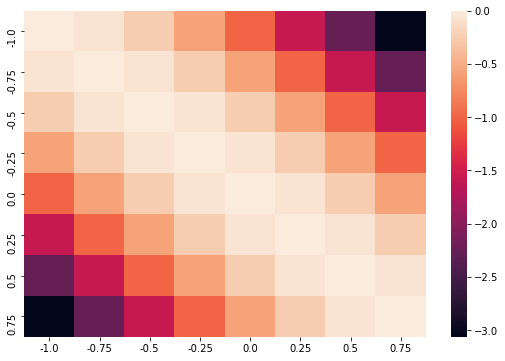

In [14]:

limit = 1
round_factor = 3
x = np.arange(-limit, limit, 0.25)
y = np.arange(-limit, limit, 0.25)
xx, yy = np.meshgrid(x, y, sparse=True)

#f = test()
z = compute_reward(xx, yy,  power=2)
z_df = (pd.DataFrame(z)
        .set_index(np.round(x, round_factor))
        .rename(columns={
            i:val for (i, val) in enumerate(np.round(y, round_factor))
        }))

f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(z_df)

### Dataset generation

### Defining pipeline and models

In [15]:
l2_val = [1e-4, 1e-2, 1e-1, 1e-0, 2, 3]
optimz = [optim.SGD, optim.Adam]

def get_models():
    grid = itertools.product(
        l2_val,
        [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler],
        optimz
    )
    
    return [generate_pipeline(l2=l2, scaler=scaler, optimizer=optimizer)
            for (l2, scaler, optimizer) in grid]

def generate_pipeline(lr=0.2, l2=0, scaler=None, optimizer=None):
    if scaler is None:
        scaler =  preprocessing.MinMaxScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    
    return pipeline

### Training and bandits

In [16]:
from river import datasets

dataset = datasets.Bananas()

In [48]:
N = 5 * 1e4
p = 40
dataset = gen_dataset(p=p, N=N, intercept=2, drift=False, noise_scale=3.0)

In [49]:
take_N = 2000
use_oracle = False
use_provided_compute = False

def compute_reward(y_pred, y_true, power=1):
    loss = np.power(np.abs(y_pred - y_true), power)
    return -loss#1 / (1 + np.sqrt(loss))
    #return 1 / (1 + np.sqrt(loss))

def gen_default_par():
    return dict(metric=metrics.MAE(), 
                reward_scaler=preprocessing.StandardScaler(),
                verbose=False,
                save_rewards=True)

bandits = {
  #  "exp3"    : Exp3Bandit(models=get_models(), gamma=0.9, **gen_default_par()),
    "epsilon" : EpsilonGreedyBandit(models=get_models(), epsilon=0.2, reduce_epsilon=.99, **gen_default_par()),
    "ucb"     : UCBBandit(models=get_models(), delta=.5, **gen_default_par()),
    "random"  : RandomBandit(models=get_models(), **gen_default_par()),
    "random2"  : RandomBandit(models=get_models(), **gen_default_par()),
}

bandits_loss = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

bandits_rewards = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

bandits_regrets = {
    "exp3": [],
    "oracle": [],
    "epsilon": [],
    "ucb" : [],
    "random" : [],
    "random2": [],
    
}

for bandit in bandits.values():
    if use_provided_compute:
        bandit.compute_reward = compute_reward
    else:
        pass    

    
bandit_oracle = OracleBandit(models=get_models(), **gen_default_par())
if use_provided_compute:
    bandit_oracle.compute_reward = compute_reward

print_every = take_N // 2

gen = gen_stream(dataset, take=take_N)
#gen = dataset.take(take_N)

for i, (x, y) in tqdm.tqdm(enumerate(gen)):
    if use_oracle:
        oracle_pred = bandit_oracle.predict_one(x, y)
        oracle_reward = compute_reward(oracle_pred, y)
        bandits_rewards["oracle"] += [oracle_reward]

    for bandit_label in bandits:
        y_pred = bandits[bandit_label].predict_one(x=x)
        bandit_reward = compute_reward(y_pred, y)
        if use_oracle:
            bandits_regrets[bandit_label] += [oracle_reward - bandit_reward]
        bandits_rewards[bandit_label] += [bandit_reward]
        #bandits_regrets[bandit_label] += [((y_pred - y) ** 2) -((oracle_pred - y) ** 2)]
        bandits_loss[bandit_label] += [(y_pred - y) ** 2]
        
        bandits[bandit_label].learn_one(x=x, y=y)
        if (i % print_every) == 0:
            print(bandit_label, ":", bandits[bandit_label].metric.get())

    if use_oracle:
        bandits_loss["oracle"] += [(oracle_pred - y) ** 2]
        bandit_oracle.learn_one(x=x, y=y)

#print(bandit.percentage_pulled)

70it [00:00, 227.66it/s]

epsilon : 9.39396397857738
ucb : 9.39396397857738
random : 9.39396397857738
random2 : 9.39396397857738


1068it [00:05, 229.73it/s]

epsilon : 3.3113190672282866
ucb : 3.8488275111051844
random : 4.541053919145727
random2 : 4.505795235872823


2000it [00:09, 213.64it/s]


### Comparing bandits

#### Comparing rolling average loss of best model for each bandit (lower is better)

<AxesSubplot:>

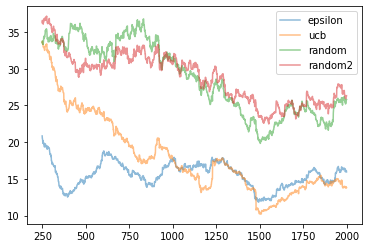

In [50]:
(pd.DataFrame({key:value[:] for key,value in bandits_loss.items() if len(value) > 0})
 .rolling(take_N//8)
 .mean()
 .iloc[:]
 .plot(alpha=.5))

### Comparing cumsum of the loss of best model for each bandit (lower is better)

<AxesSubplot:>

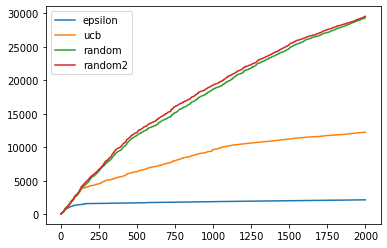

In [41]:
pd.DataFrame({key:value for key, value in bandits_loss.items() if len(value) > 0}).cumsum().plot()

### Inspecting oracle results

In [272]:
cumsum_oracle = np.array(bandit_oracle.rewards).cumsum(axis=0)
pd.Series(cumsum_oracle[-1,:]).plot(kind="bar")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<AxesSubplot:>

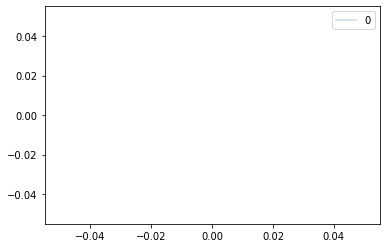

In [273]:
pd.DataFrame(cumsum_oracle).plot(alpha=.25)

### Regret analysis

<AxesSubplot:>

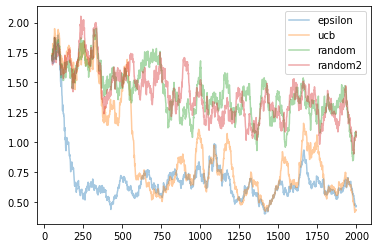

In [274]:
pd.DataFrame({key:value for key,value in bandits_regrets.items() if len(value)>0}).rolling(50).mean().plot(alpha=.4)

<AxesSubplot:>

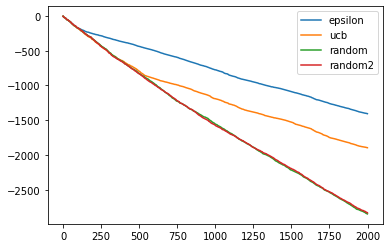

In [275]:
pd.DataFrame({key:value for key,value in bandits_rewards.items() if len(value) > 0}).cumsum().plot()

### Comparing results between bandits

In [ ]:
# bandit.rewards non pertinent car c'est scale

<AxesSubplot:>

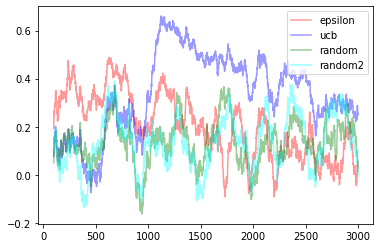

In [196]:
df_rewards = pd.DataFrame({label: bandit.rewards for (label, bandit) in bandits.items()
                           if len(bandit.rewards) >0})
#df_rewards["oracle"] = bandit_oracle.max_rewards

#sns.displot(df_rewards, kde=True)

(df_rewards
 #.iloc[:3000]
 #.cumsum()
 .rolling(100)
 .mean()
 .iloc[:]
 #.apply(np.log)
 .plot(color=["red", "blue", 'green', "cyan" ,"magenta"], alpha=.4)
)

In [409]:
df_rewards.cumsum()


,epsilon,ucb,random,random2,exp3
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,2.000000,1.947290,1.947290,1.947290,1.947290
2,2.521208,2.521614,2.521614,2.521614,2.521614
3,3.021208,3.025709,3.025709,3.025709,3.025709
4,3.610780,3.525715,3.525715,3.525715,3.525715
...,...,...,...,...,...
3995,3874.648225,3796.655893,3815.462628,3813.854116,3905.991076
3996,3875.644251,3797.649949,3816.456309,3814.822997,3906.991068
3997,3876.637764,3798.604156,3817.455127,3815.769085,3907.990920
3998,3877.633019,3799.598126,3818.453806,3816.766519,3908.990796


<AxesSubplot:>

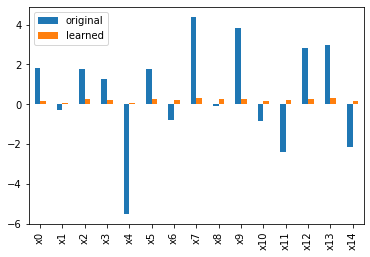

In [70]:
pd.DataFrame({"original": {feature_name:beta 
                           for (feature_name, beta) 
                           in zip(dataset.feature_names, dataset.beta)},
              "learned": bandits["ucb"].best_model["LinearRegression"].weights}).plot(kind="bar")